<a href="https://colab.research.google.com/github/CubatLin/Shopee-Code-League-2020-Competition-2--Open-Product-Detection-baseline-over-0.8/blob/master/Sentiment%20Analysis/Model%5BBaseLine%5D_Words_of_Bag_trainableFalse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+2" color="Yellow"><b>Load data from Kaggle</b></font><br><a id="1"></a>


In [1]:
def import_data_from_drive(id):
  !wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id} -O- \
  | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt && wget --content-disposition --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id}'&confirm='$(<confirm.txt)

In [2]:
%%time
import_data_from_drive('1KdBMjmOT5xWEeU6PRJwBPOinKhr17T1G')

--2021-07-05 09:34:36--  https://docs.google.com/uc?export=download&id=1KdBMjmOT5xWEeU6PRJwBPOinKhr17T1G
Resolving docs.google.com (docs.google.com)... 173.194.192.100, 173.194.192.139, 173.194.192.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.192.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/73rqp5o1lnp205jsul96b8qf5jjo49su/1625477625000/12626892632851982799/*/1KdBMjmOT5xWEeU6PRJwBPOinKhr17T1G?e=download [following]
--2021-07-05 09:34:37--  https://doc-00-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/73rqp5o1lnp205jsul96b8qf5jjo49su/1625477625000/12626892632851982799/*/1KdBMjmOT5xWEeU6PRJwBPOinKhr17T1G?e=download
Resolving doc-00-94-docs.googleusercontent.com (doc-00-94-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-00-94-docs.googleusercontent.com (doc-00-

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
%%capture
%cd /content/
!kaggle competitions download -c shopee-sentiment-analysis

In [5]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip

Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train.csv               
Archive:  /content/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.csv                


In [6]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

<font size="+2" color="Yellow"><b>Natural Language Processing is Fun!</b></font><br><a id="1"></a>

Hi, welcome to my kernel. I just want to share this fun NLP notebook to you. I believe you can do better than me, 加油！

> I'm still new to data science, so don't trust me right away, but do an experiment first.

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

plt.rcParams['figure.figsize'] = [14, 8]

pd.set_option('display.max_colwidth', -1)

In [8]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_sub = pd.read_csv('/content/sampleSubmission.csv')

train_df.drop('review_id', axis=1, inplace=True)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (146811, 2)
Test shape: (60427, 2)


In [9]:
train_df.head(3)

,review,rating
0,Ga disappointed neat products .. Meletot Hilsnyaa Speed ​​of delivery is good.,1
1,"Rdtanya replace broken glass, broken chargernya",1
2,Nyesel bngt dsni shopping antecedent photo message pictures gk according foto.di existing collagen super fit nyampe holo my house open ehhh collagen contents even in the face pdahal jg description super existing collagen originalnya.pas writing my check lg in photo captions already ma The change ma pictures that the face.,1


# Are emoji's important?

![emoji](https://miro.medium.com/max/4000/0*a_PRfzH2Qrjn3Pnj.png)

In today’s online communication, **emoji** becoming the primary language that allows us to **communicate with anyone globally** when you need to be quick and precise. **Emoji** also playing an essential part in **sentiment analysis**, so **removing them might not be a right solution**.

If a company wants to find out how people are feeling about their product, they can capture people’s emotions by analyzing emojis. This will provide an essential piece of information, and it is vital for companies to understand their customer’s feelings better.

In [10]:
!pip install emoji

找出emoji在的位置

In [11]:
import emoji  # https://pypi.org/project/emoji/

have_emoji_train_idx = []
have_emoji_test_idx = []

#20210705: emoji.UNICODE_EMOJI['en']下才有dict
for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI['en'] for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI['en'] for char in review):
        have_emoji_test_idx.append(idx)

In [12]:
train_emoji_percentage = round(len(have_emoji_train_idx) / train_df.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

test_emoji_percentage = round(len(have_emoji_test_idx) / test_df.shape[0] * 100, 2)
print(f'Test data has {len(have_emoji_test_idx)} rows that used emoji, that means {test_emoji_percentage} percent of the total')

Train data has 20048 rows that used emoji, that means 13.66 percent of the total
Test data has 7582 rows that used emoji, that means 12.55 percent of the total


## Emoji Cleaning pipeline

1. Change emoji to text
1. Delete repeated emoji
1. Change _ and - with whitespace

> For better understanding about this pipeline, i suggest you to try by yourself

In [13]:
print('Without demojize: ', train_df.loc[70266, 'review'])
print('\nUsing demojize: ', emoji.demojize(train_df.loc[70266, 'review']))

Without demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... 😊😊😊😊 😎😎😎😎

Using demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... :smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes: :smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses:


In [14]:
def emoji_cleaning(text):
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [15]:
train_df_original = train_df.copy()
test_df_original = test_df.copy()

# emoji_cleaning
train_df.loc[have_emoji_train_idx, 'review'] = train_df.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test_df.loc[have_emoji_test_idx, 'review'] = test_df.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)

In [16]:
# before cleaning
train_df_original.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... 😍😍👍👍👍 Cpt bgt sent nya.harganya's also fitting dikntong☺ Mksh yes may always be a success ...                                                                              
146787    Her material is different is different, but good overall. Seams are neat, using that is also good on the body. Create a price that much, okay really does. Pesen nyesel Gak deh here 👍
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍👍👍👍👍👍👍👍                                                                                                                                 
146801    Explore huge crowd here Children seem to like the track lay 🤣🤣🤣.                                                                                                                      
146808     Awesome awesome quality merchandise value CP Very nice! 👍                                                                                                                            
Name: review, dtype: object

In [17]:
# after cleaning
train_df.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... smiling face with heart eyes thumbs up Cpt bgt sent nya.harganya's also fitting dikntong smiling face Mksh yes may always be a success                             
146787    Her material is different different, but good overall. Seams are neat, using that also on the body. Create a price much, okay really does. Pesen nyesel Gak deh here thumbs up
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa smiling face with heart eyes thumbs up                                                                                                     
146801    Explore huge crowd here Children seem to like the track lay rolling on the floor laughing .                                                                                   
146808    Awesome awesome quality merchandise value CP Very nice! thumbs up                                                                                                             
Name: review, dtype: object

# Text cleaning

Text cleaning is an important step for natural language processing tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

### In the dataset, i found a lot of:
* emoticon
* repeated word characters (especially in bahasa)
* punctuation
* shortened words 
* noisy text

> Let's try to clean them one by one

In [18]:
def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [19]:
train_df['review'] = train_df['review'].apply(review_cleaning)
test_df['review'] = test_df['review'].apply(review_cleaning)

## Which rows have repeated words?

In [20]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)

In [21]:
print(f'Total {len(repeated_rows_train)} rows')

Total 43139 rows


## Delete repeated words characters (problem)

* I usually use regex code below to delete repeated characters in bahasa indonesia
* But many english words have a repeated characters, example: good, less, will etc, it will damage these words
* You can look example below..

In [22]:
test1 = "UUUURRGGGEENNTTT"
print(re.sub(r'(\w)\1+', r'\1', test1))

test2 = "good product quality good value for money "
print(re.sub(r'(\w)\1+', r'\1', test2))

URGENT
god product quality god value for money 


## Solution

* Repeated character in bahasa indonesia **usually repeated more than 2**, example: bagussssssssssssssssssss, tipisssss
* The solution is: **just preprocess more than 2 repeated character**, this way will not damage some english words

> Notes: some of repeated character only repeated twice, so this is NOT PERFECT way

In [23]:
test3 = "bagussssssssssssssssssss bagusssssssssssssssssss real pict"
print(re.sub(r'(\w)\1{2,}', r'\1', test3))

bagus bagus real pict


In [24]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [25]:
train_df.loc[repeated_rows_train, 'review'] = train_df.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [26]:
print('Before: ', train_df_original.loc[92129, 'review'])
print('After: ', train_df.loc[92129, 'review'])

print('\nBefore: ', train_df_original.loc[56938, 'review'])
print('After: ', train_df.loc[56938, 'review'])

print('\nBefore: ', train_df_original.loc[72677, 'review'])
print('After: ', train_df.loc[72677, 'review'])

print('\nBefore: ', train_df_original.loc[36558, 'review'])
print('After: ', train_df.loc[36558, 'review'])

Before:  Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt
After:  the best banget

Before:  Mmmmmuuuuuuuuuurrrrrrraaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh mmmeeeeerrrrrriiiiiiiiiiiiiaaaaahhhhhhhhh👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍 = ¢ ✓ € ✓ € ¢} = {¢ × `{{|}} {¢ ¢ ¢ = ¢ = {÷ € € € = {{ €€ {{
After:  murah meriah thumbs up

Before:  Bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss soft tebel bangettt its materials also makasihhh shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee the best seller friendly
After:  bagus bagus bagus bagus bagus bagus bagus bagus soft tebel banget its materials also makasih shope shope shope shope the best seller friendly

Before:  Ssuuukkkkaaa very
After:  ssuka very


## Delete the row that has noisy text

* Some of text are noisy, it will useless for training
* But some of text is not noisy, it just repeated
* If you understand many languages (just use google translate), you can choose which one are **noisy** or **just repeated**?

In [27]:
# example
train_df_original.loc[[92129, 71640, 76275, 10409], 'review']

92129    Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt                                                             
71640    ooooooooooooooooooooookkkkkkkkkkkkk.baguuuuuus.puassssss Penggiiiirimmaaan saaangggagatttt cepaaaat                               
76275    Oops mnjmmbhjhgfffffghhhHhhahahahHddedrdddxxgttttytttttt5y                                                                        
10409    กล่อง มี รอย เปิด ส่ง ช้า มาก DdddddddddddddddDdddddddddddddddDdddddddddddddddDdddddddddddddddDdddddddddddddddDddddddddddddddddddd
Name: review, dtype: object

In [28]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 2235, 5244, 10409, 11748, 12384, 14395, 15215, 17629, 20819, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train_df.drop(noisy_row, inplace=True)

## Recover shortened words to original form

* Perhaps you can get a better indonesian slang dictionary for processing this shortened words
* Since this review mostly written in english, this won't help a lot
* This is just a fun experiment :)

In [29]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [30]:
%%time
train_df['review'] = train_df['review'].apply(recover_shortened_words)

CPU times: user 25.8 s, sys: 51.9 ms, total: 25.9 s
Wall time: 25.9 s


In [31]:
print('Before: ', train_df_original['review'][4912])
print('\nAfter: ', recover_shortened_words(train_df['review'][4912]))

Before:  Thanks brg dah smpai

After:  thanks barang sudah sampai


In [32]:
print('Before: ', train_df_original['review'][9035])
print('\nAfter: ', recover_shortened_words(train_df['review'][9035]))

Before:  And I pesen knp mustard color that DTG green, I order cardy kmrn gadikirim box should Klo brg uangpun gadiselipin empty or apaa yaaa whereas an honest ka sy lg sdgkan here for sale was also pesenan org. Org also gamau yellow color green which forced me wants that loss so.

After:  and i pesen kenapa mustard color that datang green i order cardy kemarin gadikirim box should kalau barang uangpun gadiselipin empty or apa yaaa whereas an honest kakak saya lagi sedangkan here for sale was also pesenan orang orang also tidak mau yellow color green which forced me wants that loss so


In [33]:
train_df = train_df.reset_index(drop=True)

# **Words of Bag**

### Step1: delete number & word length<2

In [34]:
%%time
title_list=train_df['review']
train_translate=[]
words_len = 2

for iter in range(len(title_list)):
  tmp_sentence = re.sub(r'\d', r'', title_list[iter])
  tmp_list=[]
  for words in tmp_sentence.split(' '):
    if (len(words)>words_len) or (words=='no'):
      tmp_list.append(words)
  tmp_list = ' '.join(tmp_list)
  train_translate.append(tmp_list)

CPU times: user 1.79 s, sys: 29.1 ms, total: 1.82 s
Wall time: 1.83 s


In [35]:
print('Before: '+train_df['review'][13])
train_df['review'] = train_translate
print('After: '+train_df['review'][13])

Before: kalo rules do not want to participate in chat color change you know tidak can tell her not cultivated expect people that make his name sok sok tidak do not need the same customer yes there are your customers tidak kalo how can jualan
After: kalo rules not want participate chat color change you know tidak can tell her not cultivated expect people that make his name sok sok tidak not need the same customer yes there are your customers tidak kalo how can jualan


In [36]:
##on test data
title_list=test_df['review']
test_translate=[]

for iter in range(len(title_list)):
  tmp_sentence = re.sub(r'\d', r'', title_list[iter])
  tmp_list=[]
  for words in tmp_sentence.split(' '):
    if (len(words)>words_len) or (words=='no'):
      tmp_list.append(words)
  tmp_list = ' '.join(tmp_list)
  test_translate.append(tmp_list)


In [37]:
print('Before: '+test_df['review'][10])
test_df['review'] = test_translate
print('After: '+test_df['review'][10])

Before: thanks we have received partnered package well product quality standards the standard price the price of standard products we are satisfied with our package thank you once again thank you sweet and blessing laria merchandise
After: thanks have received partnered package well product quality standards the standard price the price standard products are satisfied with our package thank you once again thank you sweet and blessing laria merchandise


### Step 2: extract top 2000 words from train data

In [38]:
# -*- coding: utf-8 -*-
import jieba
import jieba.analyse
from tqdm import tqdm
import collections

In [39]:
#先做各ranking最常出現的70%詞
#各個rating應該會出現有不同的字 #篩選各Grouping的常出現字

def get_freq_words(rank,most_num):
  tmp_df = train_df[train_df['rating']==rank]['review']
  tmp_list = []
  for word in tmp_df:
    tmp_list.extend(jieba.lcut(word))
      
  tmp_counter = collections.Counter(tmp_list)
  #最常出現的2000個字的set
  tmp_dict = tmp_counter
  globals()["dict_"+str(rank)] = tmp_dict
  print("Done: "+"dict_"+str(rank))
  
  #最常出現的2000個字的set
  tmp_set = set(sorted(tmp_counter, key=tmp_counter.get, reverse=True)[0:most_num]) 
  globals()["set_"+str(rank)] = tmp_set
  print("Done: "+"set_"+str(rank))


In [40]:
%%time
for i in 1,2,3,4,5:
  get_freq_words(i,2000)
#得到各Group最常用的2000字

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.851 seconds.
Prefix dict has been built successfully.


Done: dict_1
Done: set_1
Done: dict_2
Done: set_2
Done: dict_3
Done: set_3
Done: dict_4
Done: set_4
Done: dict_5
Done: set_5
CPU times: user 35.4 s, sys: 182 ms, total: 35.6 s
Wall time: 35.7 s


In [41]:
set_1-= {'product','good','is','a','an','are','of','it','the','in'}
set_2-= {'product','good','is','a','an','are','of','it','the','in'}
set_3-= {'product','quality','is','a','an','are','of','it','the','in'}
set_4-= {'product','is','a','an','are','of','it','the','in'}
set_5-= {'product','is','a','an','are','of','it','the','in'}

In [42]:
def extract_word(iter_num,rating_list,review_list):
  obs_i=rating_list[iter_num]
  text=review_list[iter_num].split(' ')
  tmp_text_list=[]
  for words in text:
    if words in eval("set_%i" % obs_i):
      tmp_text_list.append(words)
  return tmp_text_list

In [43]:
%%time
train_extract_after=[]
rat_list=list(train_df['rating'])
rev_list=list(train_df['review'])

for i in range(len(train_df)):
  text_extract = extract_word(i,rat_list,rev_list)
  train_extract_after.append(text_extract)

CPU times: user 9.91 s, sys: 134 ms, total: 10 s
Wall time: 10.1 s


In [44]:
print('Before step 2: '+train_df['review'][20])
train_df['review'] = train_extract_after

def convert_list_to_string(org_list, seperator=' '):
    return seperator.join(org_list)
# Convert list of strings to string

train_df['review'] = train_df['review'].apply(convert_list_to_string)

print('After step 2: '+train_df['review'][20])

Before step 2: think the danger fabric tightness serasa rubber less tasty understandably heck price too cheap
After step 2: think danger fabric rubber less tasty heck price too cheap


In [45]:
train_df.loc[range(10,18),:]

,review,rating
10,not bubble paper tapi its please not buyer,1
11,quality standards,1
12,very different each photograph tidak,1
13,kalo not want chat color change you know tidak can tell her not expect people that make his name tidak not need same customer yes there your customers tidak kalo how can jualan,1
14,small headset sound long side and delivery,1
15,received with different size ordered dislike,1
16,face were slightly bent this because was not packed bubble wrap,1
17,very small waist,1


### Step 3: **Information Sampling on train data(not necessary)**
* 20210705改動: informantion>0.2

In [46]:
%%time
tmp_rat = list(train_df['rating'])
tmp_rev = list(train_df['review'])

prob_list=[]
words_list = []
for iter in range(len(train_df['rating'])):
  tmp_score=0;tmp_group=tmp_rat[iter]
  tmp_sentence = tmp_rev[iter]
  tmp_groupset= eval("dict_%i" % tmp_group)
  words_cnt=0
  for words in tmp_sentence.split(' '):
    words_cnt+=1
    tmp_score+=tmp_groupset[words]
  words_list.append(words_cnt)
  prob_list.append(round(tmp_score/sum(tmp_groupset.values()),7))

CPU times: user 32.8 s, sys: 118 ms, total: 32.9 s
Wall time: 33 s


In [47]:
prob_array = np.array(prob_list)
words_array = np.array(words_list)

In [48]:
train_df['Prob_info'] = prob_array
train_df['Words_cnt'] = words_array

train_df.head(3)

,review,rating,Prob_info,Words_cnt
0,tidak disappointed neat products speed delivery,1,0.012377,6
1,replace broken glass broken,1,0.002066,4
2,nyesel banget disini shopping antecedent photo message pictures tidak according existing super fit nyampe house open contents even face pdahal juga description super existing pas writing check lagi photo already change pictures that face,1,0.025403,34


In [49]:
train_df['Prob_avg'] =train_df['Prob_info']/train_df['Words_cnt']

train_df.head(3)

,review,rating,Prob_info,Words_cnt,Prob_avg
0,tidak disappointed neat products speed delivery,1,0.012377,6,0.002063
1,replace broken glass broken,1,0.002066,4,0.000516
2,nyesel banget disini shopping antecedent photo message pictures tidak according existing super fit nyampe house open contents even face pdahal juga description super existing pas writing check lagi photo already change pictures that face,1,0.025403,34,0.000747


In [50]:
#Sampling informantion
train_df = train_df[train_df['Prob_info']>=train_df['Prob_info'].quantile(0.2)]

In [51]:
train_df = train_df.drop(['Prob_info','Words_cnt','Prob_avg'],axis=1)
train_df.head(3)

,review,rating
0,tidak disappointed neat products speed delivery,1
2,nyesel banget disini shopping antecedent photo message pictures tidak according existing super fit nyampe house open contents even face pdahal juga description super existing pas writing check lagi photo already change pictures that face,1
3,sent light blue suit goods tidak want refund,1


In [52]:
train_df.groupby(['rating']).apply(lambda x : len(x))

rating
1    10096
2    8735 
3    28312
4    35220
5    35030
dtype: int64

# WordCloud + EDA

Let's compare the words in the reviews between rating 1, 3 and 5

In [53]:
rating_1 = train_df[train_df['rating'] == 1]['review']
rating_3 = train_df[train_df['rating'] == 3]['review']
rating_5 = train_df[train_df['rating'] == 5]['review']

rating_1_text = ' '.join([text for text in rating_1])
rating_3_text = ' '.join([text for text in rating_3])
rating_5_text = ' '.join([text for text in rating_5])

### Rating 1

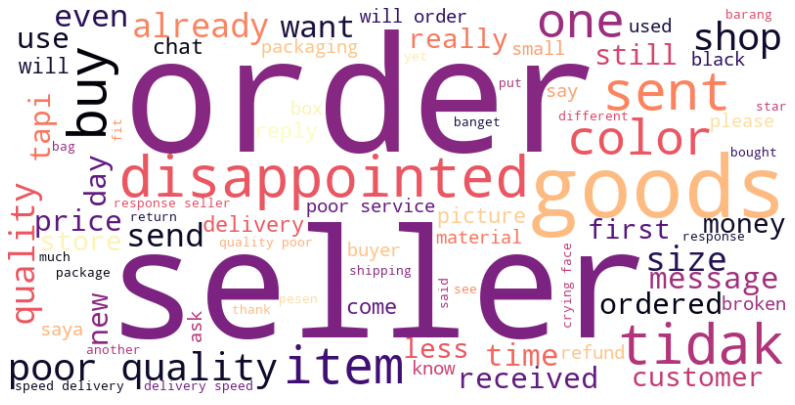

In [54]:
from wordcloud import WordCloud, ImageColorGenerator

rating_1_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80).generate(rating_1_text)

plt.imshow(rating_1_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Rating 3

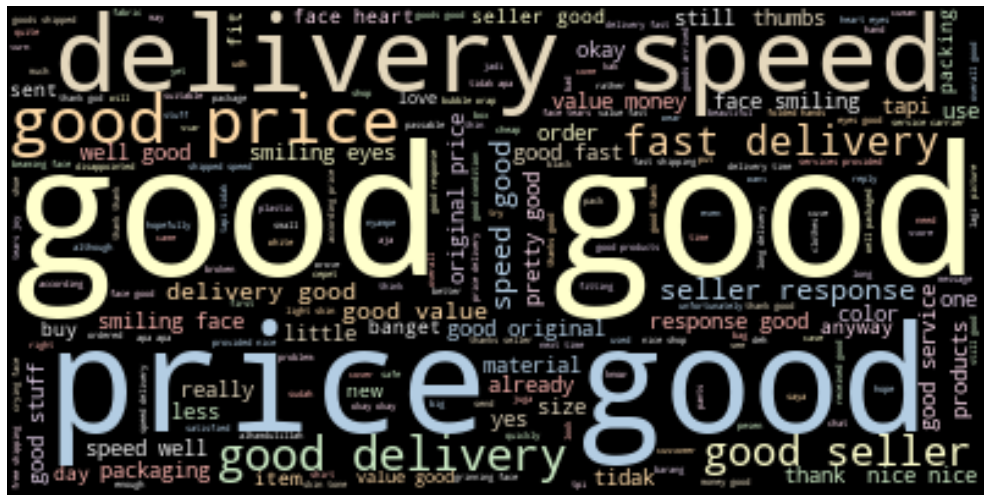

In [55]:
from PIL import Image

# Load image

rating_3_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1').generate(rating_3_text)

plt.imshow(rating_3_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

### Rating 5

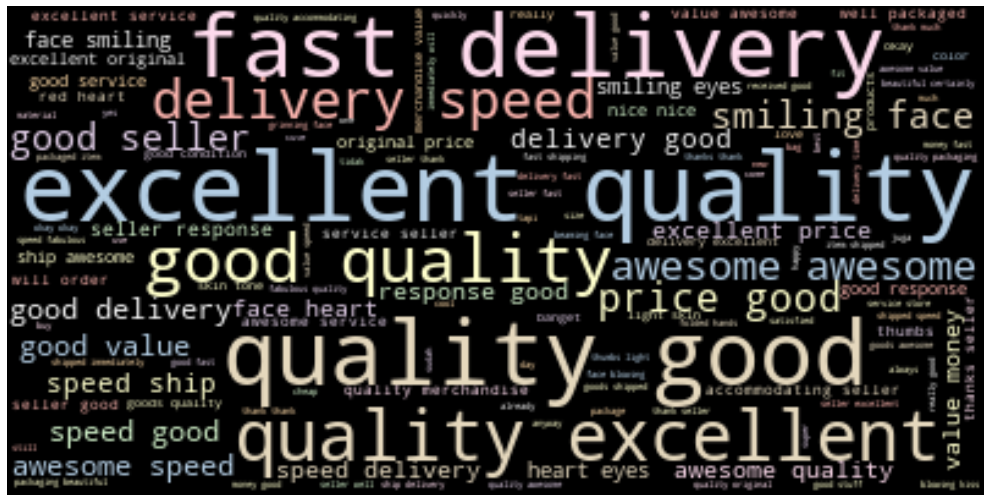

In [56]:
# Load image

rating_5_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1').generate(rating_5_text)

plt.imshow(rating_5_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Rating Comparison

* Class imbalanced
* Rating 1 + 2 (negative) - only 19% from the entire dataset
* Rating 4 + 5 (positive) - 56.77% from the entire dataset

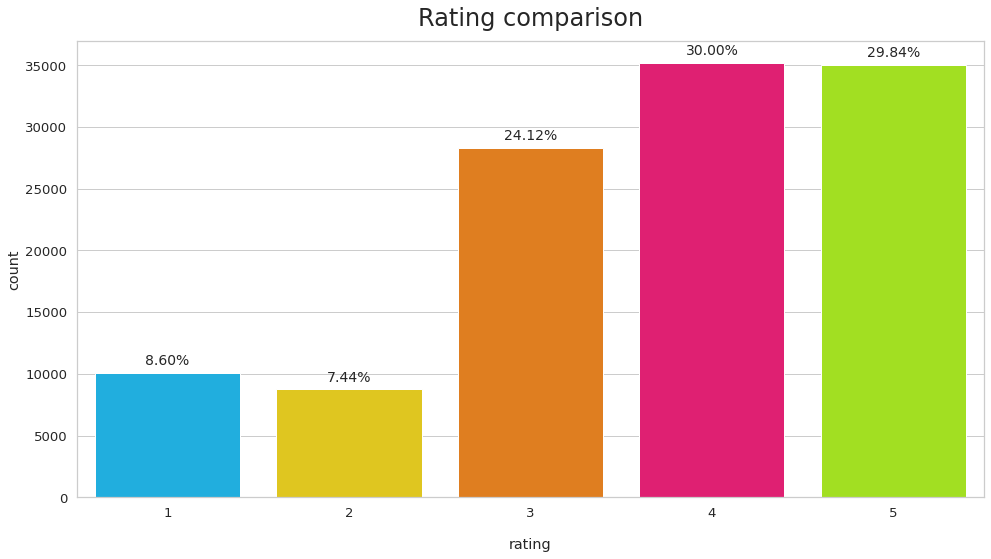

In [57]:
ax = sns.countplot(train_df['rating'])

for val in ax.patches:
    pct = '{:.2f}%'.format(100 * val.get_height() / train_df.shape[0])
    xpos = val.get_x() + val.get_width() / 2.
    ypos = val.get_height()
    ax.annotate(pct, (xpos, ypos), ha='center', va='center', fontsize=14, xytext=(0, 12), textcoords='offset points')
    
plt.title('Rating comparison', fontsize=24, pad=15)
plt.xlabel('rating', labelpad=18)
plt.tight_layout()
plt.show()

# Usually more data we have, better performance we can achieve

Deep Learning models typically have millions of parameters, thus require large amounts of data for training in order for over-fit avoidance and better model generalization. However, collecting a large annotated data samples is time-consuming and expensive. One technique aiming to address such a data hungry problem is data augmentation.

Proper data augmentation is useful to boost up your model performance. Augmentation is very popular in computer vision area. Image can be augmented easily by flipping, rotation, random cropping etc. It is proved that augmentation is one of the anchor to success of computer vision model.

In Natural Language Processing field, it is hard to augmenting text due to high complexity of language. Not every word we can replace it by others such as a, an, the. Also, not every word has synonym. Even changing a word, the context will be totally difference.

There are several techniques to do **text augmentation**:
* Synonym Replacement: Randomly replace n words in the sentences with their synonyms
* Random Insertion: Insert random synonyms of words in a sentence, this is done n times
* Random Deletion: Random removal for each word in the sentence with a probability p
* Contextualized Word Embeddings
* Text Generation (GPT-2 or XLNet)

> For detail you can [check here](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28). In this notebook we'll use [nlpaug](https://pypi.org/project/nlpaug/) library. If you're interested, you also can check their tutorial example.

In [58]:
!pip install nlpaug -q

In [59]:
!pip install nltk
import nltk
nltk.download('wordnet')  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

In [61]:
aug_syn = naw.SynonymAug(aug_src='wordnet')

In [62]:
print('Origin: ',train_df.loc[146735,'review'])

Origin:  excellent quality excellent quality very accommodating seller very accommodating seller well packaged item shipped immediately


In [63]:
nltk.download('averaged_perceptron_tagger')  
print('After Augumentation: ',aug_syn.augment(train_df.loc[146735,'review']) )

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
After Augumentation:  excellent quality excellent lineament very accommodating seller very accommodating seller well packaged item ship now


# Modeling

In [64]:
!pip3 install sentencepiece

In [65]:
import sentencepiece

In [66]:
!pip install --no-cache-dir transformers sentencepiece

In [67]:
%load_ext autoreload
%autoreload 2

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.5.0


In [69]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [70]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-1), loss='categorical_crossentropy', metrics=['accuracy']) #lr=1e-5)
    
    return model

In [71]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.29.111.90:8470


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.29.111.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.29.111.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Load model from https://huggingface.co/jplu/tf-xlm-roberta-large

In [72]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 10 #Ethan:建議3~5,6以上很容易overfit,樣本太少
BATCH_SIZE = 16 * strategy.num_replicas_in_sync #16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-base' # bert-base-multilingual-uncased #jplu/tf-xlm-roberta-large #jplu/tf-xlm-roberta-base

In [73]:
# since tf.keras reads your data take 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later(dont forget!!)
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df['rating'] = train_df['rating'].map(rating_mapper_encode)

In [74]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.12,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((103305,), (14088,), (103305, 5), (14088, 5))

In [76]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL,use_fast=False)

In [77]:
#use BERT tokenizer to encode data
MAX_LEN = 256

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [78]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(256) #1024
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

一開始layer都是trainable,記得關掉

In [79]:
transformer_layer = TFAutoModel.from_pretrained(MODEL)

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [80]:
transformer_layer.layers[0].trainable

True

In [81]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    for layer in transformer_layer.layers:
      layer.trainable = False  
    for layer in transformer_layer.layers[-10:-1]:
        layer.trainable=True
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 256)]             0         
_________________________________________________________________
tfxlm_roberta_model_1 (TFXLM TFBaseModelOutputWithPool 278043648 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3845      
Total params: 278,047,493
Trainable params: 3,845
Non-trainable params: 278,043,648
_________________________________________________________________
CPU times: user 21.3 s, sys: 1min 33s, total: 1min 55s
Wall time: 3min 2s


In [82]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 5) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 5) dtype=float32>]


807/807 [==============================] - ETA: 0s - loss: 2.0460 - accuracy: 0.2799

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 5) dtype=float32>]


807/807 [==============================] - 119s 111ms/step - loss: 2.0460 - accuracy: 0.2799 - val_loss: 1.5547 - val_accuracy: 0.2973
Epoch 2/10
807/807 [==============================] - 72s 89ms/step - loss: 1.8859 - accuracy: 0.2876 - val_loss: 2.0529 - val_accuracy: 0.3001
Epoch 3/10
807/807 [==============================] - 72s 89ms/step - loss: 1.9275 - accuracy: 0.2870 - val_loss: 1.6513 - val_accuracy: 0.2764
Epoch 4/10
807/807 [==============================] - 72s 89ms/step - loss: 1.9409 - accuracy: 0.2886 - val_loss: 1.6983 - val_accuracy: 0.2735
Epoch 5/10
807/807 [==============================] - 72s 89ms/step - loss: 1.9446 - accuracy: 0.2899 - val_loss: 1.6319 - val_accuracy: 0.2660
Epoch 6/10
807/807 [==============================] - 72s 89ms/step - loss: 1.9053 - accuracy: 0.2916 - val_loss: 1.5198 - val_accuracy: 0.2979
Epoch 7/10
807/807 [==============================] - 72s 89ms/step - loss: 1.9401 - accuracy: 0.2902 - val_loss: 1.5556 - val_accuracy: 0.2902
E

效能較差原因，因為是用base model

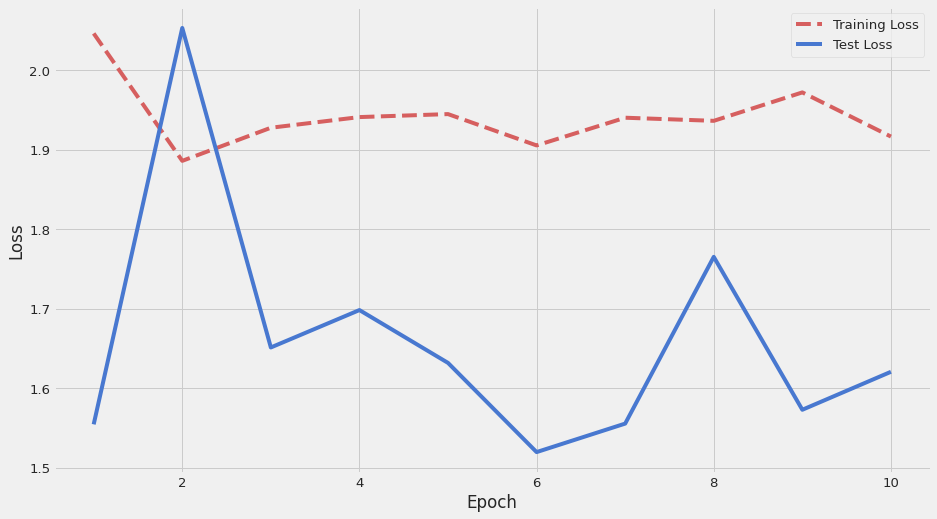

In [83]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## **Do TTA on Test data & Prediction**

In [84]:
aug_syn = naw.SynonymAug(aug_src='wordnet')

In [85]:
'''
def TTA_func(input_test_data,i):
    #Initial
    N_len = len(input_test_data);
    tmp_rev = list(input_test_data)
    tmp_test_rev=[];
    
    for seq in range(len(N_len)):
        tmp_test_rev.append( aug_syn.augment(tmp_rev[seq]) )
    test_x_encode = pd.Series(tmp_test_rev)#series
    
    #Encode & Predict
    func_X_test = regular_encode(input_test_data.values, tokenizer, maxlen=MAX_LEN)
    tmp_test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(func_X_test)
        .batch(BATCH_SIZE)
    )
    
    tmp_pred = model.predict(tmp_test_dataset, verbose=1)
    globals()["test_pred_"+str(i)] = tmp_pred
    print("Done: "+"test_pred_"+str(i))
 '''   

'\ndef TTA_func(input_test_data,i):\n    #Initial\n    N_len = len(input_test_data);\n    tmp_rev = list(input_test_data)\n    tmp_test_rev=[];\n    \n    for seq in range(len(N_len)):\n        tmp_test_rev.append( aug_syn.augment(tmp_rev[seq]) )\n    test_x_encode = pd.Series(tmp_test_rev)#series\n    \n    #Encode & Predict\n    func_X_test = regular_encode(input_test_data.values, tokenizer, maxlen=MAX_LEN)\n    tmp_test_dataset = (\n        tf.data.Dataset\n        .from_tensor_slices(func_X_test)\n        .batch(BATCH_SIZE)\n    )\n    \n    tmp_pred = model.predict(tmp_test_dataset, verbose=1)\n    globals()["test_pred_"+str(i)] = tmp_pred\n    print("Done: "+"test_pred_"+str(i))\n '

In [86]:
'''
for i in range(3):
  TTA_func(test_df['review'],i)
'''

"\nfor i in range(3):\n  TTA_func(test_df['review'],i)\n"

In [87]:
#test data prediction
pred = model.predict(test_dataset, verbose=1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>]


473/473 [==============================] - 47s 90ms/step


In [88]:
print(pred)

[[0.1242493  0.01608248 0.06685722 0.44959068 0.34322032]
 [0.06527878 0.03656947 0.16611321 0.33289543 0.39914307]
 [0.06633205 0.03488096 0.1550537  0.3387259  0.4050074 ]
 ...
 [0.10033465 0.01774892 0.01600877 0.47212818 0.39377946]
 [0.06795143 0.036625   0.161716   0.3353026  0.398405  ]
 [0.35765237 0.03481469 0.0139979  0.27656907 0.31696588]]


In [89]:
# don't forget to save for ensemble
np.save('test_0731_055', pred)

In [90]:
pred_sentiment = np.argmax(pred, axis=1)

print(pred_sentiment)

[3 4 4 ... 3 4 0]


In [91]:
submission = pd.DataFrame({'review_id': test_df['review_id'],
                           'rating': pred_sentiment})

## Last, don't forget to convert back our rating values to 1 - 5

In [92]:
submission['rating'] = submission['rating'].map(rating_mapper_decode)

submission.to_csv('sub_0731_5.csv', index=False)

# References

* [Emoticon and Emoji in Text Mining](https://medium.com/towards-artificial-intelligence/emoticon-and-emoji-in-text-mining-7392c49f596a)
* [Data Augmentation in NLP](https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28)